In [15]:
import json

import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgi

import fig_settings as fs
cmap = fs.cmap


from lcs import *

In [16]:
fs.set_fonts({"font.family": "sans-serif"})
#cmap = cmr.gem

In [17]:
models = ["Erdos-Renyi", "SBM", "Watts-Strogatz", "CM", "clustered_network"]
cfs = [
    "SIS",
    r"Threshold, $\tau=2$",
    r"Threshold, $\tau=3$",
]
keys = ["p", "epsilon", "p", "alpha", "size"]
titles = ["Erdös-Rényi", "SBM", "Small-World", "Power-law CM", "Clustered"]
labels = [r"$p$", r"$\epsilon$", r"$p$", r"$\alpha$", r"$s$"]
xticks = [
    [0, 0.5, 1],
    [0, 0.5, 1],
    [-6, -4, -2, 0],
    [1.5, 2, 2.5, 3, 3.5, 4],
    [1, 7, 13, 19],
]
xticklabels = [
    ["0", "0.5", "1"],
    ["0", "0.5", "1"],
    [r"$10^{-6}$", r"$10^{-4}$", r"$10^{-2}$", r"$10^{0}$"],
    ["1.5", "2", "2.5", "3", "3.5", "4"],
    ["1", "7", "13", "19"],
]
convert_to_log = [False, False, True, False, False]

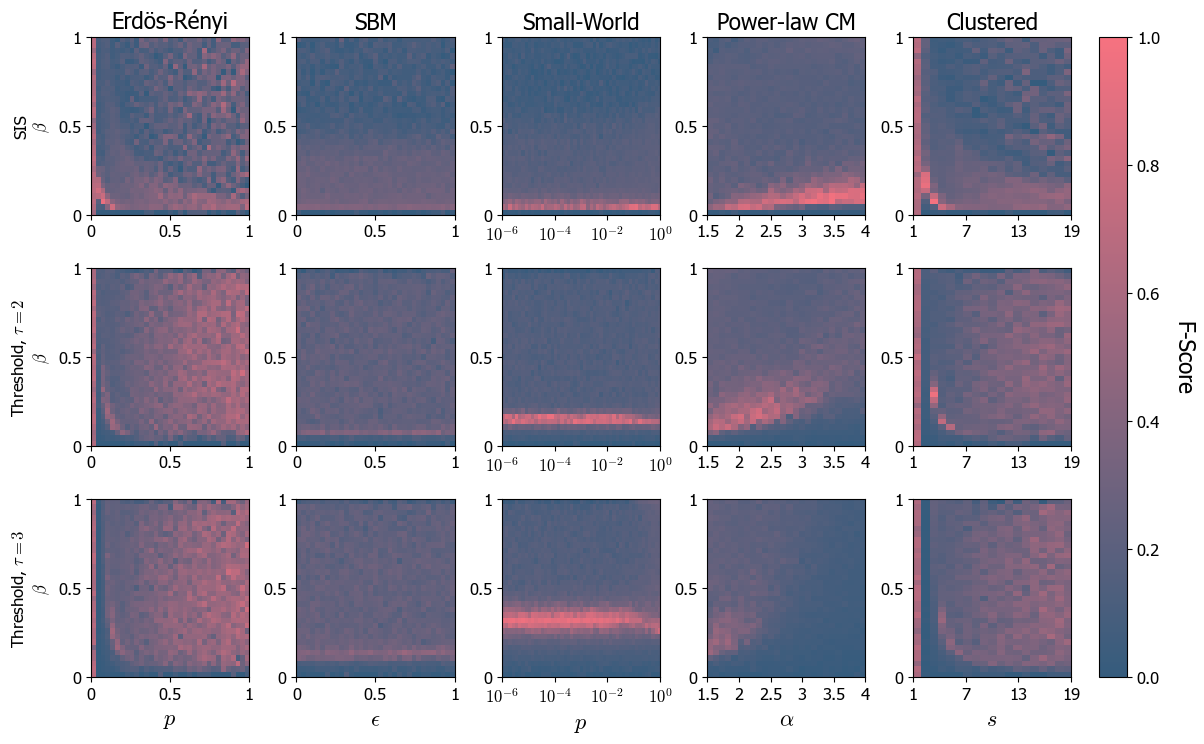

In [18]:
fig, axes = plt.subplots(len(cfs), len(models), figsize=(14, 8))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    sps = np.array(data["sps"], dtype=float)

    if convert_to_log[i]:
        var = np.log10(var)

    for j, cf in enumerate(cfs):
        sps_summary = sps[j].mean(axis=2).T
        im = axes[j, i].imshow(
            to_imshow_orientation(sps_summary),
            extent=(min(var), max(var), min(b), max(b)),
            vmin=0,
            vmax=1,
            aspect="auto",
            cmap=cmap,
        )
        axes[j, i].set_xlim([min(var), max(var)])
        axes[j, i].set_ylim([min(b), max(b)])
        axes[j, i].set_xticks(xticks[i], xticklabels[i])
        axes[j, i].set_yticks([0, 0.5, 1], [0, 0.5, 1])

        if j == 0:
            axes[j, i].set_title(titles[i])
        if i == 0:
            axes[j, i].set_ylabel(f"{cfs[j]}\n" + r"$\beta$")
        if j == len(cfs) - 1:
            axes[j, i].set_xlabel(labels[i], fontsize=16)
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F-Score", fontsize=16, rotation=270, labelpad=25)
# plt.tight_layout()

plt.savefig("Figures/Fig2/generative_models_sps.png", dpi=1000)
plt.savefig("Figures/Fig2/generative_models_sps.pdf", dpi=1000)

In [19]:
def visualize_networks(i, ax):
    n = 50
    match i:
        case 0:
            A = erdos_renyi(n, 0.1, seed=0)
            e = [(i, j) for i, j in nx.Graph(A).edges]
        case 1:
            A = sbm(n, 10, 0.9, seed=0)
            e = [(i, j) for i, j in nx.Graph(A).edges]
        case 2:
            A = watts_strogatz(n, 6, 0.03, seed=0)
            e = [(i, j) for i, j in nx.Graph(A).edges]
        case 3:
            A = truncated_power_law_configuration(n, 2, 20, 3, seed=0)
            e = [(i, j) for i, j in nx.Graph(A).edges]
        case 4:
            k = 2  # each node belongs to two cliques
            clique_size = 4
            k1 = k * np.ones(n)
            num_cliques = round(sum(k1) / clique_size)
            k2 = clique_size * np.ones(num_cliques)
            A = clustered_network(k1, k2, seed=0)
            e = [(i, j) for i, j in nx.Graph(A).edges]

    H = xgi.Hypergraph(e)

    node_size = 3
    dyad_lw = 0.5
    node_lw = 0.5

    match i:
        case 0:
            pos = xgi.pairwise_spring_layout(H, seed=2)
        case 1:
            pos = xgi.pca_transform(xgi.pairwise_spring_layout(H, seed=2))
        case 2:
            pos = xgi.circular_layout(H)
        case 3:
            # sorted_nodes = [n for n, _ in sorted(H.nodes.degree.asdict().items(), key=lambda d: d[1])]
            # Hnew = xgi.Hypergraph()
            # Hnew.add_nodes_from(sorted_nodes)
            # Hnew.add_edges_from(e)
            # pos = xgi.circular_layout(Hnew)
            pos = xgi.pairwise_spring_layout(H, seed=2)
        case 4:
            pos = xgi.pairwise_spring_layout(H, seed=2)
    xgi.draw(H, ax=ax, pos=pos, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)

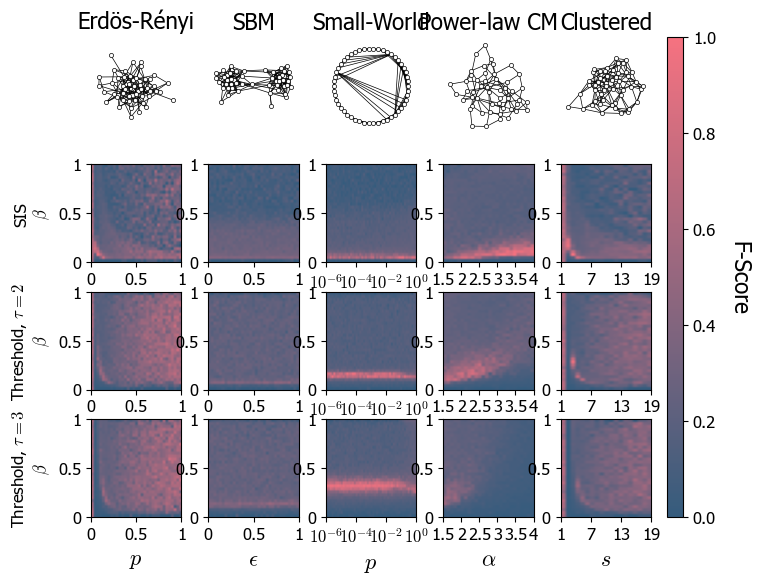

In [20]:
fig, axes = plt.subplots(len(cfs) + 1, len(models), figsize=(8, 6))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    sps = np.array(data["sps"], dtype=float)

    if convert_to_log[i]:
        var = np.log10(var)

    for j, cf in enumerate(cfs):
        sps_summary = sps[j].mean(axis=2).T
        im = axes[j + 1, i].imshow(
            to_imshow_orientation(sps_summary),
            extent=(min(var), max(var), min(b), max(b)),
            vmin=0,
            vmax=1,
            aspect="auto",
            cmap=cmap,
        )
        axes[j + 1, i].set_xlim([min(var), max(var)])
        axes[j + 1, i].set_ylim([min(b), max(b)])
        axes[j + 1, i].set_xticks(xticks[i], xticklabels[i])
        axes[j + 1, i].set_yticks([0, 0.5, 1], [0, 0.5, 1])

        if i == 0:
            axes[j + 1, i].set_ylabel(f"{cfs[j]}\n" + r"$\beta$")

        if j + 1 == len(cfs):
            axes[j + 1, i].set_xlabel(labels[i], fontsize=16)

fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F-Score", fontsize=16, rotation=270, labelpad=25)

for i, m in enumerate(models):
    visualize_networks(i, axes[0, i])
    axes[0, i].set_title(titles[i])

plt.savefig("Figures/Fig2/generative_models_sps.png", dpi=1000)
plt.savefig("Figures/Fig2/generative_models_sps.pdf", dpi=1000)

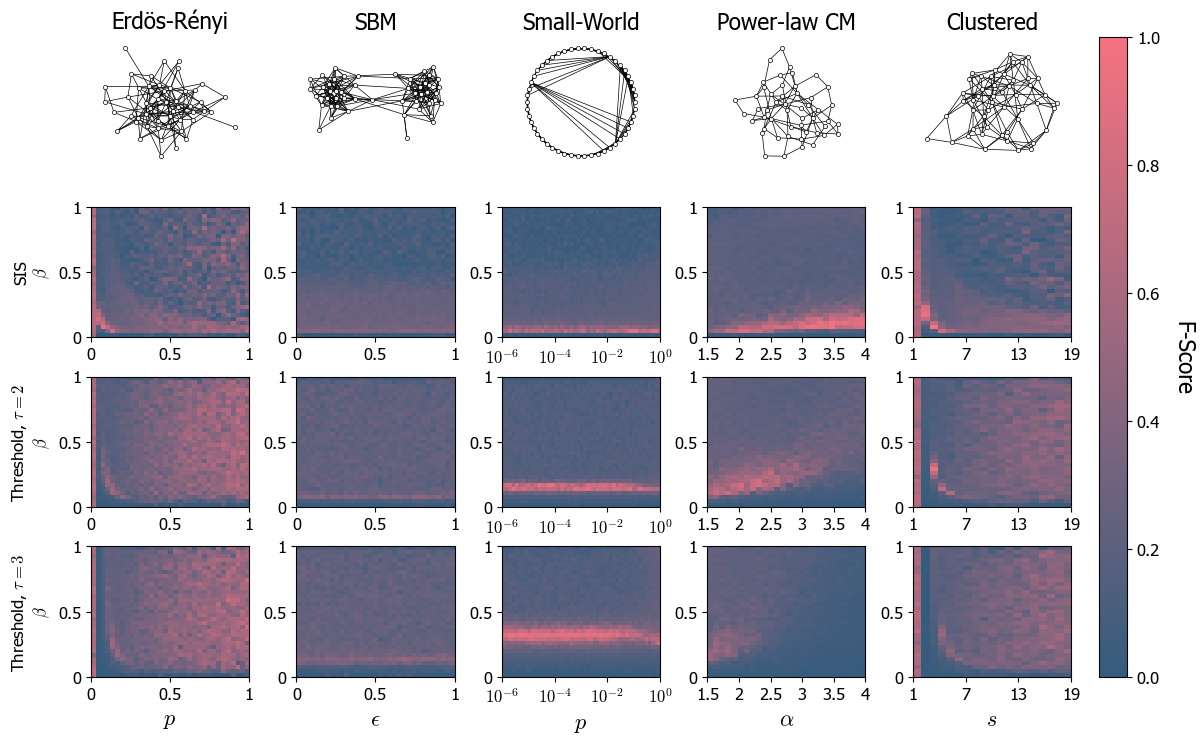

In [21]:
fig, axes = plt.subplots(len(cfs) + 1, len(models), figsize=(14, 8))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    sps = np.array(data["sps"], dtype=float)

    if convert_to_log[i]:
        var = np.log10(var)

    for j, cf in enumerate(cfs):
        sps_summary = sps[j].mean(axis=2).T
        im = axes[j + 1, i].imshow(
            to_imshow_orientation(sps_summary),
            extent=(min(var), max(var), min(b), max(b)),
            vmin=0,
            vmax=1,
            aspect="auto",
            cmap=cmap,
        )
        axes[j + 1, i].set_xlim([min(var), max(var)])
        axes[j + 1, i].set_ylim([min(b), max(b)])
        axes[j + 1, i].set_xticks(xticks[i], xticklabels[i])
        axes[j + 1, i].set_yticks([0, 0.5, 1], [0, 0.5, 1])

        if i == 0:
            axes[j + 1, i].set_ylabel(f"{cfs[j]}\n" + r"$\beta$")

        if j + 1 == len(cfs):
            axes[j + 1, i].set_xlabel(labels[i], fontsize=16)

fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"F-Score", fontsize=16, rotation=270, labelpad=25)

for i, m in enumerate(models):
    visualize_networks(i, axes[0, i])
    axes[0, i].set_title(titles[i])


plt.savefig("Figures/Fig2/generative_models_sps.png", dpi=1000)
plt.savefig("Figures/Fig2/generative_models_sps.pdf", dpi=1000)

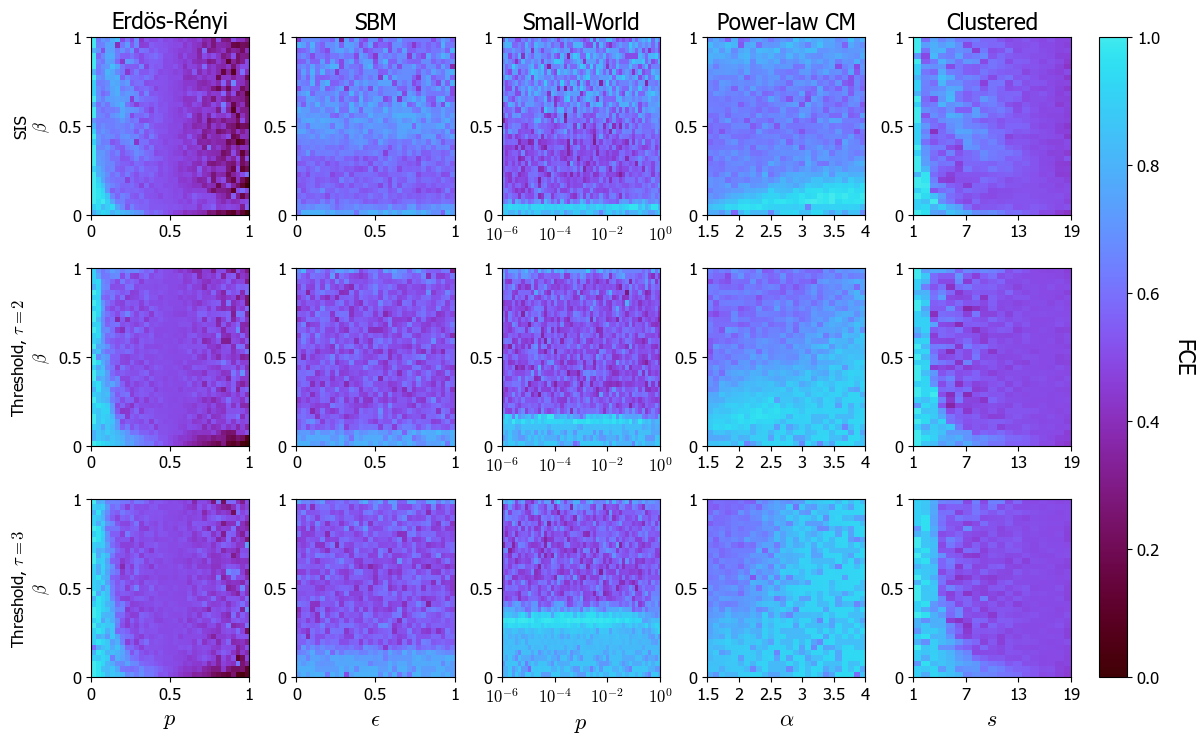

In [8]:
fig, axes = plt.subplots(len(cfs), len(models), figsize=(14, 8))
for i, m in enumerate(models):
    with open(f"Data/{m.lower()}.json") as file:
        data = json.load(file)
    var = np.array(data[keys[i]], dtype=float)
    b = np.array(data["beta"], dtype=float)
    fce = np.array(data["fce"], dtype=float)

    if convert_to_log[i]:
        var = np.log10(var)

    for j, cf in enumerate(cfs):
        fce_summary = fce[j].mean(axis=2).T
        im = axes[j, i].imshow(
            to_imshow_orientation(fce_summary),
            extent=(min(var), max(var), min(b), max(b)),
            vmin=0,
            vmax=1,
            aspect="auto",
            cmap=cmap,
        )
        axes[j, i].set_xlim([min(var), max(var)])
        axes[j, i].set_ylim([min(b), max(b)])
        axes[j, i].set_xticks(xticks[i], xticklabels[i])
        axes[j, i].set_yticks([0, 0.5, 1], [0, 0.5, 1])

        if j == 0:
            axes[j, i].set_title(titles[i])
        if i == 0:
            axes[j, i].set_ylabel(f"{cfs[j]}\n" + r"$\beta$")
        if j == len(cfs) - 1:
            axes[j, i].set_xlabel(labels[i], fontsize=16)
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"FCE", fontsize=16, rotation=270, labelpad=25)

plt.savefig("Figures/Fig2/generative_models_fce.png", dpi=1000)
plt.savefig("Figures/Fig2/generative_models_fce.pdf", dpi=1000)

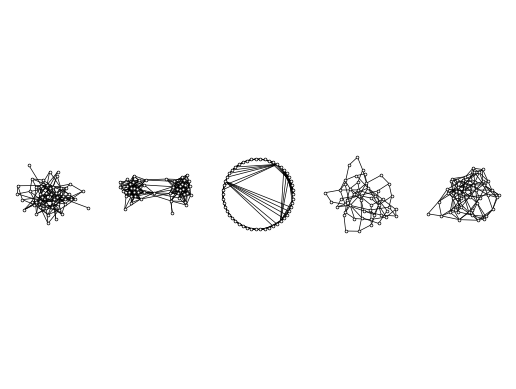

In [9]:
n = 50

A = erdos_renyi(n, 0.1, seed=0)
e1 = [(i, j) for i, j in nx.Graph(A).edges]

A = sbm(n, 10, 0.9, seed=0)
e2 = [(i, j) for i, j in nx.Graph(A).edges]

A = watts_strogatz(n, 6, 0.03, seed=0)
e3 = [(i, j) for i, j in nx.Graph(A).edges]

A = truncated_power_law_configuration(n, 2, 20, 3, seed=0)
e4 = [(i, j) for i, j in nx.Graph(A).edges]

k = 2  # each node belongs to two cliques
clique_size = 4
k1 = k * np.ones(n)
num_cliques = round(sum(k1) / clique_size)
k2 = clique_size * np.ones(num_cliques)
A = clustered_network(k1, k2, seed=0)
e5 = [(i, j) for i, j in nx.Graph(A).edges]

H1 = xgi.Hypergraph(e1)
H2 = xgi.Hypergraph(e2)
H3 = xgi.Hypergraph(e3)
H4 = xgi.Hypergraph(e4)
H5 = xgi.Hypergraph(e5)

node_size = 2
dyad_lw = 0.5
node_lw = 0.5

plt.figure()
plt.subplot(151)
pos1 = xgi.pairwise_spring_layout(H1, seed=2)
xgi.draw(H1, pos=pos1, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)

plt.subplot(152)
pos2 = xgi.pca_transform(xgi.pairwise_spring_layout(H2, seed=2))
xgi.draw(H2, pos=pos2, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)

plt.subplot(153)
pos3 = xgi.circular_layout(H3)
xgi.draw(H3, pos=pos3, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)

plt.subplot(154)
pos4 = xgi.pairwise_spring_layout(H4, seed=2)
xgi.draw(H4, pos=pos4, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)

plt.subplot(155)
pos5 = xgi.pairwise_spring_layout(H5, seed=2)
xgi.draw(H5, pos=pos5, node_size=node_size, node_lw=node_lw, dyad_lw=dyad_lw)
plt.savefig("test2.png", dpi=1000)